(601, 500, 3)


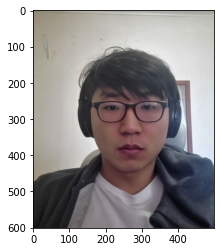

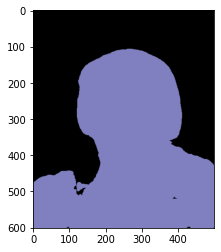

background
person
(601, 500)


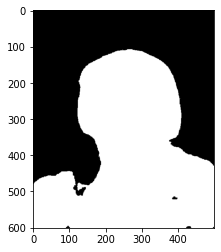

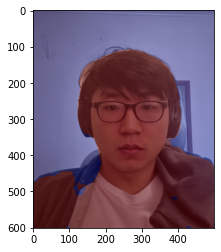

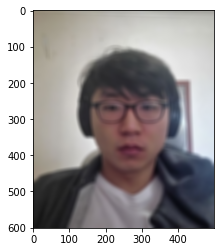

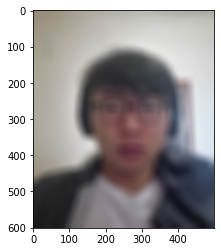

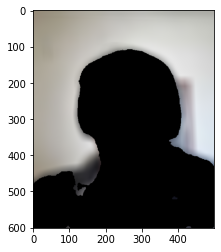

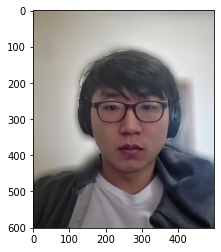

In [2]:
import os
import urllib
import cv2
import numpy as np
from pixellib.semantic import semantic_segmentation
from matplotlib import pyplot as plt

img_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/a4.jpg'  
img_orig = cv2.imread(img_path) 

print(img_orig.shape)

# cv2.cvtColor(입력 이미지, 색상 변환 코드): 입력 이미지의 색상 채널을 변경
# cv2.COLOR_BGR2RGB: 이미지 색상 채널을 변경 (BGR 형식을 RGB 형식으로 변경)
# plt.imshow(): 저장된 데이터를 이미지의 형식으로 표시, 입력은 RGB(A) 데이터 혹은 2D 스칼라 데이터
# https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.imshow.html
# plt.show(): 현재 열려있는 모든 figure를 표시 (여기서 figure는 이미지, 그래프 등)
# https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.show.html
plt.imshow(cv2.cvtColor(img_orig, cv2.COLOR_BGR2RGB))
plt.show()

# 저장할 파일 이름을 결정합니다
# 1. os.getenv(x)함수는 환경 변수x의 값을 포함하는 문자열 변수를 반환합니다. model_dir 에 "/aiffel/human_segmentation/models" 저장
# 2. #os.path.join(a, b)는 경로를 병합하여 새 경로 생성 model_file 에 "/aiffel/aiffel/human_segmentation/models/deeplabv3_xception_tf_dim_ordering_tf_kernels.h5" 저장
# 1
model_dir = os.getenv('HOME')+'/aiffel/human_segmentation/models' 
# 2
model_file = os.path.join(model_dir, 'deeplabv3_xception_tf_dim_ordering_tf_kernels.h5') 

# PixelLib가 제공하는 모델의 url입니다
model_url = 'https://github.com/ayoolaolafenwa/PixelLib/releases/download/1.1/deeplabv3_xception_tf_dim_ordering_tf_kernels.h5' 

# 다운로드를 시작합니다
urllib.request.urlretrieve(model_url, model_file) # urllib 패키지 내에 있는 request 모듈의 urlretrieve 함수를 이용해서 model_url에 있는 파일을 다운로드 해서 model_file 파일명으로 저장

model = semantic_segmentation() #PixelLib 라이브러리 에서 가져온 클래스를 가져와서 semantic segmentation을 수행하는 클래스 인스턴스를 만듬
model.load_pascalvoc_model(model_file) # pascal voc에 대해 훈련된 예외 모델(model_file)을 로드하는 함수를 호출

segvalues, output = model.segmentAsPascalvoc(img_path) # segmentAsPascalvoc()함 수 를 호출 하여 입력된 이미지를 분할, 분할 출력의 배열을 가져옴, 분할 은 pacalvoc 데이터로 학습된 모델을 이용

#pascalvoc 데이터의 라벨종류
LABEL_NAMES = [
    'background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus',
    'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike',
    'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tv'
]
len(LABEL_NAMES)
output_rotated = cv2.rotate(output, cv2.ROTATE_90_CLOCKWISE)

#segmentAsPascalvoc() 함수 를 호출하여 입력된 이미지를 분할한 뒤 나온 결과값 중 output을 matplotlib을 이용해 출력
plt.imshow(output_rotated)
plt.show()
segvalues # segmentAsPascalvoc() 함수를 호출하여 입력된 이미지를 분할한 뒤 나온 결과값 중 배열값을 출력

#segvalues에 있는 class_ids를 담겨있는 값을 통해 pacalvoc에 담겨있는 라벨을 출력
for class_id in segvalues['class_ids']:
    print(LABEL_NAMES[class_id])

# 아래 코드를 이해하지 않아도 좋습니다
# PixelLib에서 그대로 가져온 코드입니다
# 주목해야 할 것은 생상 코드 결과물이예요!

#컬러맵 만들기 
colormap = np.zeros((256, 3), dtype = int)
ind = np.arange(256, dtype=int)


for shift in reversed(range(8)):
    for channel in range(3):
        colormap[:, channel] |= ((ind >> channel) & 1) << shift
    ind >>= 3

colormap[:20] #생성한 20개의 컬러맵 출력

colormap[15] #컬러맵 15에 해당하는 배열 출력 (pacalvoc에 LABEL_NAMES 15번째인 사람)

seg_color = (128,128,192) # 색상순서 변경 - colormap의 배열은 RGB 순이며 output의 배열은 BGR 순서로 채널 배치가 되어 있어서

# output의 픽셀 별로 색상이 seg_color와 같다면 1(True), 다르다면 0(False)이 됩니다
# seg_color 값이 person을 값이 므로 사람이 있는 위치를 제외하고는 gray로 출력
# cmap 값을 변경하면 다른 색상으로 확인이 가능함
seg_map = np.all(output_rotated==seg_color, axis=-1) 
print(seg_map.shape) 
plt.imshow(seg_map, cmap='gray')
plt.show()

# 원본이미지를 img_show에 할당한뒤 이미지 사람이 있는 위치와 배경을 분리해서 표현한 color_mask 를 만든뒤 두 이미지를 합쳐서 출력
img_show = img_orig.copy()

# True과 False인 값을 각각 255과 0으로 바꿔줍니다
img_mask = seg_map.astype(np.uint8) * 255

# 255와 0을 적당한 색상으로 바꿔봅니다
color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)

# 원본 이미지와 마스트를 적당히 합쳐봅니다
# 0.6과 0.4는 두 이미지를 섞는 비율입니다.
img_show = cv2.addWeighted(img_show, 0.6, color_mask, 0.4, 0.0)

plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

# (13,13)은 blurring kernel size를 뜻합니다
# 다양하게 바꿔보세요
img_orig_blur = cv2.blur(img_orig, (13,13))

# plt.imshow(): 저장된 데이터를 이미지의 형식으로 표시한다.
# cv2.cvtColor(입력 이미지, 색상 변환 코드): 입력 이미지의 색상 채널을 변경
# cv2.COLOR_BGR2RGB: 원본이 BGR 순서로 픽셀을 읽다보니
# 이미지 색상 채널을 변경해야함 (BGR 형식을 RGB 형식으로 변경)   
plt.imshow(cv2.cvtColor(img_orig_blur, cv2.COLOR_BGR2RGB))
plt.show()

# (13,13)은 blurring kernel size를 뜻합니다
# 다양하게 바꿔보세요
img_orig_blur = cv2.blur(img_orig, (30,30))

# plt.imshow(): 저장된 데이터를 이미지의 형식으로 표시한다.
# cv2.cvtColor(입력 이미지, 색상 변환 코드): 입력 이미지의 색상 채널을 변경
# cv2.COLOR_BGR2RGB: 원본이 BGR 순서로 픽셀을 읽다보니
# 이미지 색상 채널을 변경해야함 (BGR 형식을 RGB 형식으로 변경)   
plt.imshow(cv2.cvtColor(img_orig_blur, cv2.COLOR_BGR2RGB))
plt.show()

# cv2.cvtColor(입력 이미지, 색상 변환 코드): 입력 이미지의 색상 채널을 변경
# cv2.COLOR_BGR2RGB: 원본이 BGR 순서로 픽셀을 읽다보니
# 이미지 색상 채널을 변경해야함 (BGR 형식을 RGB 형식으로 변경) 
img_mask_color = cv2.cvtColor(img_mask, cv2.COLOR_GRAY2BGR)

# cv2.bitwise_not(): 이미지가 반전됩니다. 배경이 0 사람이 255 였으나
# 연산을 하고 나면 배경은 255 사람은 0입니다.
img_bg_mask = cv2.bitwise_not(img_mask_color)

# cv2.bitwise_and()을 사용하면 배경만 있는 영상을 얻을 수 있습니다.
# 0과 어떤 수를 bitwise_and 연산을 해도 0이 되기 때문에 
# 사람이 0인 경우에는 사람이 있던 모든 픽셀이 0이 됩니다. 결국 사람이 사라지고 배경만 남아요!
img_bg_blur = cv2.bitwise_and(img_orig_blur, img_bg_mask)
plt.imshow(cv2.cvtColor(img_bg_blur, cv2.COLOR_BGR2RGB))
plt.show()

# np.where(조건, 참일때, 거짓일때)
# 세그멘테이션 마스크가 255인 부분만 원본 이미지 값을 가지고 오고 
# 아닌 영역은 블러된 이미지 값을 사용합니다.
img_concat = np.where(img_mask_color==255, img_orig, img_bg_blur)
# plt.imshow(): 저장된 데이터를 이미지의 형식으로 표시한다.
# cv2.cvtColor(입력 이미지, 색상 변환 코드): 입력 이미지의 색상 채널을 변경
# cv2.COLOR_BGR2RGB: 원본이 BGR 순서로 픽셀을 읽다보니 
# 이미지 색상 채널을 변경해야함 (BGR 형식을 RGB 형식으로 변경)
plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
plt.show()

(888, 500, 3)


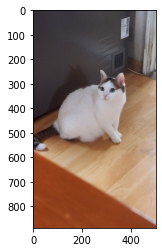

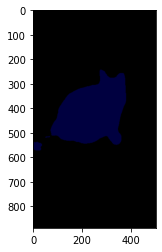

background
cat
(888, 500)


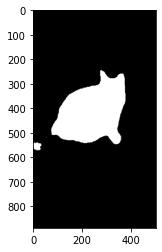

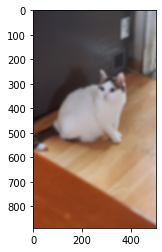

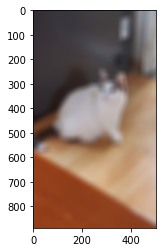

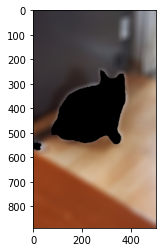

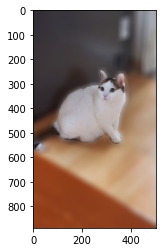

In [3]:
import os
import urllib
import cv2
import numpy as np
from pixellib.semantic import semantic_segmentation
from matplotlib import pyplot as plt

# 이미지 경로 설정
img_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/a6.jpg'  
img_orig = cv2.imread(img_path) 

print(img_orig.shape)

# 이미지 시각화
plt.imshow(cv2.cvtColor(img_orig, cv2.COLOR_BGR2RGB))
plt.show()

# 모델 디렉토리 및 파일 설정
model_dir = os.getenv('HOME')+'/aiffel/human_segmentation/models' 
model_file = os.path.join(model_dir, 'deeplabv3_xception_tf_dim_ordering_tf_kernels.h5') 

# 모델 다운로드 (이미 다운로드 되어 있다면 생략 가능)
if not os.path.exists(model_file):
    model_url = 'https://github.com/ayoolaolafenwa/PixelLib/releases/download/1.1/deeplabv3_xception_tf_dim_ordering_tf_kernels.h5' 
    urllib.request.urlretrieve(model_url, model_file)

# 모델 로드
model = semantic_segmentation()
model.load_pascalvoc_model(model_file)

# 이미지 세그멘테이션
segvalues, output = model.segmentAsPascalvoc(img_path)

# Pascal VOC 라벨
LABEL_NAMES = [
    'background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus',
    'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike',
    'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tv'
]

# 세그멘테이션 결과 시각화
output_rotated = cv2.rotate(output, cv2.ROTATE_90_CLOCKWISE)
plt.imshow(output_rotated)
plt.show()

# 클래스 정보 출력
for class_id in segvalues['class_ids']:
    print(LABEL_NAMES[class_id])

# 컬러맵 생성
colormap = np.zeros((256, 3), dtype = int)
ind = np.arange(256, dtype=int)

for shift in reversed(range(8)):
    for channel in range(3):
        colormap[:, channel] |= ((ind >> channel) & 1) << shift
    ind >>= 3

# 'cat' 클래스의 색상 추출 (클래스 ID 8)
cat_class_id = 8
cat_color = tuple(colormap[cat_class_id])

# BGR 순서로 변환 (OpenCV는 BGR 사용)
seg_color = (cat_color[2], cat_color[1], cat_color[0])

# 마스크 생성
seg_map = np.all(output_rotated == seg_color, axis=-1)
print(seg_map.shape)
plt.imshow(seg_map, cmap='gray')
plt.show()

# 원본 이미지 복사
img_show = img_orig.copy()

# 마스크를 255과 0으로 변환
img_mask = seg_map.astype(np.uint8) * 255

# 마스크 색상 변환
img_mask_color = cv2.cvtColor(img_mask, cv2.COLOR_GRAY2BGR)

# 배경 블러링
# (13,13)은 블러링 커널 사이즈입니다. 필요에 따라 변경 가능합니다.
img_orig_blur = cv2.blur(img_orig, (13,13))
plt.imshow(cv2.cvtColor(img_orig_blur, cv2.COLOR_BGR2RGB))
plt.show()

img_orig_blur = cv2.blur(img_orig, (30,30))
plt.imshow(cv2.cvtColor(img_orig_blur, cv2.COLOR_BGR2RGB))
plt.show()

# 배경 마스크 생성
img_bg_mask = cv2.bitwise_not(img_mask_color)

# 블러링된 배경 생성
img_bg_blur = cv2.bitwise_and(img_orig_blur, img_bg_mask)
plt.imshow(cv2.cvtColor(img_bg_blur, cv2.COLOR_BGR2RGB))
plt.show()

# 원본 이미지와 블러링된 배경 결합
img_concat = np.where(img_mask_color == 255, img_orig, img_bg_blur)
plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
plt.show()


Matplotlib is building the font cache; this may take a moment.


(601, 500, 3)


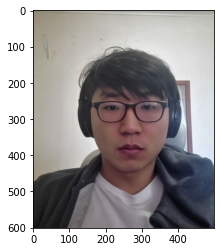

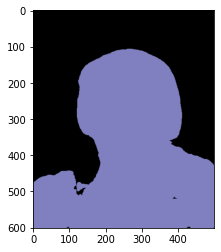

{'class_ids': array([ 0, 15]), 'masks': array([[False, False, False, ...,  True,  True, False],
       [False, False, False, ...,  True,  True,  True],
       [False, False, False, ...,  True,  True,  True],
       ...,
       [False, False, False, ...,  True,  True,  True],
       [False, False, False, ...,  True,  True,  True],
       [False, False, False, ...,  True,  True,  True]])}
background
person
(601, 500)


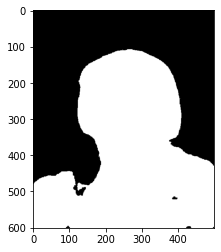

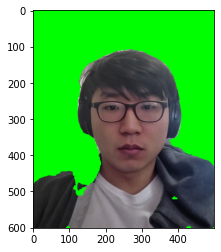

In [1]:
import os
import urllib
import cv2
import numpy as np
from pixellib.semantic import semantic_segmentation
from matplotlib import pyplot as plt

# 이미지 경로 설정
img_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/a4.jpg'  
img_orig = cv2.imread(img_path) 

print(img_orig.shape)

# 이미지 시각화
plt.imshow(cv2.cvtColor(img_orig, cv2.COLOR_BGR2RGB))
plt.show()

# 모델 디렉토리 및 파일 설정
model_dir = os.getenv('HOME')+'/aiffel/human_segmentation/models' 
model_file = os.path.join(model_dir, 'deeplabv3_xception_tf_dim_ordering_tf_kernels.h5') 

# 모델 다운로드
model_url = 'https://github.com/ayoolaolafenwa/PixelLib/releases/download/1.1/deeplabv3_xception_tf_dim_ordering_tf_kernels.h5' 
urllib.request.urlretrieve(model_url, model_file)

# 모델 로드
model = semantic_segmentation()
model.load_pascalvoc_model(model_file)

# 이미지 세그멘테이션
segvalues, output = model.segmentAsPascalvoc(img_path)

# Pascal VOC 라벨
LABEL_NAMES = [
    'background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus',
    'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike',
    'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tv'
]

output_rotated = cv2.rotate(output, cv2.ROTATE_90_CLOCKWISE)

# 세그멘테이션 결과 시각화
plt.imshow(output_rotated)
plt.show()
print(segvalues)

# 라벨 출력
for class_id in segvalues['class_ids']:
    print(LABEL_NAMES[class_id])


# 사람 클래스의 색상 (Pascal VOC에서 'person' 클래스의 색상)
seg_color = (128,128,192)  # BGR 순서

# 마스크 생성
seg_map = np.all(output_rotated==seg_color, axis=-1) 
print(seg_map.shape)
plt.imshow(seg_map, cmap='gray')
plt.show()

# 원본 이미지 복사
img_show = img_orig.copy()

# 마스크를 255과 0으로 변환
img_mask = seg_map.astype(np.uint8) * 255

# 마스크 색상 변환
img_mask_color = cv2.cvtColor(img_mask, cv2.COLOR_GRAY2BGR)

# 초록색 배경 이미지 생성
green_bg = np.full_like(img_orig, (0, 255, 0))  # BGR 순서로 초록색

# 마스크를 사용하여 원본 이미지와 초록색 배경을 결합
# img_mask_color==255: 사람 부분, 그렇지 않은 부분은 배경
img_concat = np.where(img_mask_color==255, img_orig, green_bg)

# 결과 이미지 시각화
plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
plt.show()


![ㅇㅇ](https://i.imgur.com/69g5uya.png)

옷이 제대로 포함되지 않았음


인물모드 사진의 문제 해결방안

인물모드 사진에서는 Semantic Segmentation의 부정확성으로 인해 경계가 흐릿하거나 잘못된 부분이 포함되는 경우가 많습니다.
얕은 피사계 심도 개념을 적용한 깊이 기반 세그멘테이션 개선 방식이 중요한거같은데
 
입력 이미지를 Semantic Segmentation 모델과 Depth Estimation 모델에 동시에 전달
세그멘테이션 마스크와 깊이 맵을 결합하여 보완된 마스크 생성.
깊이 값에 따라 배경의 블러링 강도를 가변적으로 적용하여 자연스러운 심도 효과 구현.
보완된 이미지를 최종 결과로 제공. 의 메커니즘을 이용하면  

원래 모델보다 정교하게 아웃포커싱 모드를 구현 할 수 있을것 같음 



# 회고

인물 마스크가 90도 회전되어서 나타나는데 왜 그런지 모르겠어서 그냥 결과물을 90도 돌려버렸다
기존 마스크의 경계를 정교화하여 자연스러운 배경 블러링을 구현하는 것이 핵심이었던거 같은데 시간이 부족했다.. 
90도 돌려져서 나오는 이유를 더 알아봐야겠다 






